# 득점 기대값 (Run Expectancy)

한 타자가 타석에 들어섰을 때 상황(Start)   
한 타자의 타석이 종료되었을 때 상황(End)   
   
주자가 루 상에 없는 경우 숫자 0으로, 있는 경우 숫자 1로 표현   
(1루에만 주자가 있을 경우: 100   
2,3루에 주자가 있을 경우: 011)   
   
아웃카운트 상황을 주자 상황 뒤에 숫자 0,1,2,3으로 표현   
(1아웃 1루에 주자 있는 경우: 100 1   
2아웃 2루에 주자가 있는 경우: 010 2)   
   
   
각 상황(주자 상황과 아웃카운트 상황)에서, 이닝이 종료되었을 때의 득점 수 = 각 상황의 득점 기대값

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

pd.set_option('display.max_columns', 100)

In [2]:
# 2017 MLB 데이터
MLBAM17 = pd.read_csv("data/MLBAM17.csv")
MLBAM17.drop(['Unnamed: 0'], axis=1, inplace=True)
MLBAM17.head()

,inning,batterId,pitcherId,event,x,y,ab_num,timestamp,stand,throws,runnerMovement,half,balls,strikes,endOuts,actionId,description,game_type,home_team,home_teamId,home_lg,away_team,away_teamId,away_lg,venueId,stadium,field_teamId,playerId.1B,playerId.2B,playerId.3B,playerId.C,playerId.CF,playerId.LF,playerId.RF,playerId.SS,batterPos,batterName,pitcherName,runsOnPlay,startOuts,runsInInning,runsITD,runsFuture,start1B,start2B,start3B,end1B,end2B,end3B,outsInInning,startCode,endCode,fielderId,gameId,isPA,isAB,isHit,isBIP,our.x,our.y,r,theta
0,1,458731,502042,Flyout,65.59,123.50,1,2017-04-02 17:12:18,L,R,NaN,top,2,2,1,NaN,Brett Gardner flies out to left fielder Mallex...,R,tba,139,AL,nya,147,AL,12,Tropicana Field,139,489149,543543,446334,519083,595281,605480,519306,542921,LF,Gardner,Archer,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,605480.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,-148.267814,188.423160,239.763700,2.237490
1,1,596142,502042,Groundout,128.19,193.88,2,2017-04-02 17:15:42,R,R,NaN,top,0,0,2,NaN,"Gary Sanchez grounds out sharply, pitcher Chri...",R,tba,139,AL,nya,147,AL,12,Tropicana Field,139,489149,543543,446334,519083,595281,605480,519306,542921,C,"Sanchez, G",Archer,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,502042.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,7.961190,12.777835,15.055020,1.013603
2,1,595885,502042,Walk,NaN,NaN,3,2017-04-02 17:16:48,L,R,[595885::1B::Walk],top,4,1,2,NaN,Greg Bird walks.,R,tba,139,AL,nya,147,AL,12,Tropicana Field,139,489149,543543,446334,519083,595281,605480,519306,542921,1B,Bird,Archer,0,2,0,0,0,NaN,NaN,NaN,595885.0,NaN,NaN,3,0,1,NaN,gid_2017_04_02_nyamlb_tbamlb_1,True,False,False,False,NaN,NaN,NaN,NaN
3,1,407812,502042,Groundout,153.48,157.29,4,2017-04-02 17:19:09,R,R,[595885:1B:::Groundout],top,3,1,3,NaN,"Yankees challenged (play at 1st), call on the ...",R,tba,139,AL,nya,147,AL,12,Tropicana Field,139,489149,543543,446334,519083,595281,605480,519306,542921,DH,Holliday,Archer,0,2,0,0,0,595885.0,NaN,NaN,NaN,NaN,NaN,3,1,0,543543.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,71.076710,104.094437,126.045827,0.971701
4,1,572816,547888,Single,140.75,73.31,5,2017-04-02 17:24:43,L,R,[572816::1B::Single],bottom,0,1,0,NaN,Corey Dickerson singles on a sharp line drive ...,R,tba,139,AL,nya,147,AL,12,Tropicana Field,147,595885,516770,452104,596142,453056,458731,592450,591720,DH,"Dickerson, C",Tanaka,0,0,3,0,3,NaN,NaN,NaN,572816.0,NaN,NaN,3,0,1,NaN,gid_2017_04_02_nyamlb_tbamlb_1,True,True,True,True,39.306818,313.680887,316.134030,1.446138


In [3]:
MLBAM17.columns

Index(['inning', 'batterId', 'pitcherId', 'event', 'x', 'y', 'ab_num',
       'timestamp', 'stand', 'throws', 'runnerMovement', 'half', 'balls',
       'strikes', 'endOuts', 'actionId', 'description', 'game_type',
       'home_team', 'home_teamId', 'home_lg', 'away_team', 'away_teamId',
       'away_lg', 'venueId', 'stadium', 'field_teamId', 'playerId.1B',
       'playerId.2B', 'playerId.3B', 'playerId.C', 'playerId.CF',
       'playerId.LF', 'playerId.RF', 'playerId.SS', 'batterPos', 'batterName',
       'pitcherName', 'runsOnPlay', 'startOuts', 'runsInInning', 'runsITD',
       'runsFuture', 'start1B', 'start2B', 'start3B', 'end1B', 'end2B',
       'end3B', 'outsInInning', 'startCode', 'endCode', 'fielderId', 'gameId',
       'isPA', 'isAB', 'isHit', 'isBIP', 'our.x', 'our.y', 'r', 'theta'],
      dtype='object')

runsFuture: 현재 상황에서 이닝이 끝날 때까지 더해진 득점

In [4]:
re17 = MLBAM17[['batterName','batterId','event', 'half', 'home_team', 'away_team','start1B', 'start2B', 'start3B', 'end1B', 'end2B', 'end3B',
                   'startOuts','endOuts','runsFuture','runsOnPlay','outsInInning',
                   'stand', 'throws','venueId', 'stadium', 'batterPos']].copy()

In [5]:
# Start 상황에서
# 1B, 2B, 3B가 null일 경우(주자가 없음), 0으로
# 1B, 2B, 3B가 null이 아닐 경우(주자가 있음), 1으로

re17['Start1'] = np.where(pd.isnull(re17['start1B']),0,1)
re17['Start2'] = np.where(pd.isnull(re17['start2B']),0,1)
re17['Start3'] = np.where(pd.isnull(re17['start3B']),0,1)
re17['Start_State'] = (re17['Start1'].astype(str) + re17['Start2'].astype(str) + re17['Start3'].astype(str)+" " + re17['startOuts'].astype(str))

In [6]:
# End 상황에서
# 1B, 2B, 3B가 null일 경우(주자가 없음), 0으로
# 1B, 2B, 3B가 null이 아닐 경우(주자가 있음), 1으로

re17['End1'] = np.where(pd.isnull(re17['end1B']),0,1)
re17['End2'] = np.where(pd.isnull(re17['end2B']),0,1)
re17['End3'] = np.where(pd.isnull(re17['end3B']),0,1)
re17['End_State'] = (re17['End1'].astype(str) + re17['End2'].astype(str) + re17['End3'].astype(str) +" " + re17['endOuts'].astype(str))

In [7]:
re17['event'].value_counts()

Strikeout               39924
Groundout               33144
Single                  26907
Flyout                  19811
Walk                    14854
Lineout                 11247
Pop Out                  8670
Double                   8360
Home Run                 6102
Grounded Into DP         3801
Forceout                 3657
Hit By Pitch             1760
Field Error              1578
Sac Fly                  1144
Intent Walk               970
Sac Bunt                  924
Triple                    793
Double Play               423
Runner Out                396
Fielders Choice Out       308
Bunt Groundout            281
Strikeout - DP            148
Bunt Pop Out              134
Fielders Choice            93
Fan interference           44
Catcher Interference       43
Batter Interference        36
Sac Fly DP                 22
Bunt Lineout               14
Triple Play                 7
Name: event, dtype: int64

In [8]:
# Field Error: 파울 타구를 에러를 내서 잡지 못했을 경우, 주자 상황은 변하지 않고 아웃카운트도 변하지 않는다.
#              run_expectancy에 영향을 미치지 않기 때문에 제외한다.
# 끝내기: 9회말의 경우, 아웃카운트에 상관없이 경기가 끝나서 3아웃까지 채우지 않고도 경기가 끝나버린다.
#         3아웃을 기준으로 측정한 run_expectancy에 영향이 가기 때문에 제외한다.

re17 = re17[((re17.Start_State != re17.End_State) | (re17.runsOnPlay > 0)) & (re17.outsInInning == 3)]
re17

,batterName,batterId,event,half,home_team,away_team,start1B,start2B,start3B,end1B,end2B,end3B,startOuts,endOuts,runsFuture,runsOnPlay,outsInInning,stand,throws,venueId,stadium,batterPos,Start1,Start2,Start3,Start_State,End1,End2,End3,End_State
0,Gardner,458731,Flyout,top,tba,nya,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,3,L,R,12,Tropicana Field,LF,0,0,0,000 0,0,0,0,000 1
1,"Sanchez, G",596142,Groundout,top,tba,nya,NaN,NaN,NaN,NaN,NaN,NaN,1,2,0,0,3,R,R,12,Tropicana Field,C,0,0,0,000 1,0,0,0,000 2
2,Bird,595885,Walk,top,tba,nya,NaN,NaN,NaN,595885.0,NaN,NaN,2,2,0,0,3,L,R,12,Tropicana Field,1B,0,0,0,000 2,1,0,0,100 2
3,Holliday,407812,Groundout,top,tba,nya,595885.0,NaN,NaN,NaN,NaN,NaN,2,3,0,0,3,R,R,12,Tropicana Field,DH,1,0,0,100 2,0,0,0,000 3
4,"Dickerson, C",572816,Single,bottom,tba,nya,NaN,NaN,NaN,572816.0,NaN,NaN,0,0,3,0,3,L,R,12,Tropicana Field,DH,0,0,0,000 0,1,0,0,100 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185590,Vincej,572227,Runner Out,top,chn,cin,571740.0,608385.0,NaN,NaN,NaN,NaN,2,3,0,0,3,R,R,17,Wrigley Field,UN,1,1,0,110 2,0,0,0,000 3
185591,"Davis, T",543089,Groundout,bottom,chn,cin,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,3,R,R,17,Wrigley Field,UN,0,0,0,000 0,0,0,0,000 1
185592,Almora Jr.,546991,Home Run,bottom,chn,cin,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,3,R,R,17,Wrigley Field,UN,0,0,0,000 1,0,0,0,000 1
185593,Freeman,502273,Groundout,bottom,chn,cin,NaN,NaN,NaN,NaN,NaN,NaN,1,2,0,0,3,L,R,17,Wrigley Field,UN,0,0,0,000 1,0,0,0,000 2


In [9]:
start_RunExp = re17.groupby(['Start_State'])['runsFuture'].mean().reset_index().rename(columns={'runsFuture':'Start_RE'})
start_RunExp

,Start_State,Start_RE
0,000 0,0.516375
1,000 1,0.272176
2,000 2,0.108038
3,001 0,1.436482
4,001 1,0.953586
5,001 2,0.381186
6,010 0,1.154829
7,010 1,0.711650
8,010 2,0.336702
9,011 0,2.051376


## 해석
0아웃 0주자 상황에서의 득점 기대값은 약 0.498점: 각 이닝이 시작할 때는 0.498점을 얻을 것이라는 기대를 할 수 있다.   
1아웃 0주자 상황에서의 득점 기대값은 약 0.268점: 0아웃 0주자 상황보다 득점 기대값이 크게 낮아졌다.   
2아웃 0주자 상황에서의 득점 기대값은 약 0.099점: 2아웃 0주자 상황은 득점 기대값이 거의 0점에 가깝게 낮아졌다.   
   
0아웃 1루 주자 상황에서의 득점 기대값은 약 1.437점: 0아웃 1루주자 상황에서는 평균 1.437점 득점 기대값을 가진다.   
...   
   
0아웃 1루2루3루 주자 상황(무사 만루)에서의 득점 기대값은 약 2.327점: 무사 만루 상황에서 평균 2.327점 득점 기대값을 가진다.   


# 

# Run Value

타자가 타석에 들어가면 Start_State와 End_State가 있다.   
End_State의 경우 Start_State에 3아웃 상황(이닝 종료)이 추가된다.   
3아웃 상황은 주자 상황과 상관없이 이닝이 종료되기 때문에 득점 기대값은 0이다.   
   
   
Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)   
1득점당 Run Value는 1로 계산   
타석 후의 득점 기대값의 변화량 (End State - Start State)     

In [10]:
outs_3 = [pd.Series(['000 3', 0], index=start_RunExp.columns),
          pd.Series(['001 3', 0], index=start_RunExp.columns),
          pd.Series(['010 3', 0], index=start_RunExp.columns),
          pd.Series(['011 3', 0], index=start_RunExp.columns),
          pd.Series(['100 3', 0], index=start_RunExp.columns),
          pd.Series(['101 3', 0], index=start_RunExp.columns),
          pd.Series(['110 3', 0], index=start_RunExp.columns),
          pd.Series(['111 3', 0], index=start_RunExp.columns)]

In [11]:
start_RunExp = start_RunExp.append(outs_3, ignore_index=True)
end_RunExp = start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})
end_RunExp

,End_State,End_RE
0,000 0,0.516375
1,000 1,0.272176
2,000 2,0.108038
3,001 0,1.436482
4,001 1,0.953586
5,001 2,0.381186
6,010 0,1.154829
7,010 1,0.711650
8,010 2,0.336702
9,011 0,2.051376


In [12]:
re17 = pd.merge(re17, start_RunExp, on=['Start_State'], how='left')
re17 = pd.merge(re17, end_RunExp, on=['End_State'], how='left')
re17.head()

,batterName,batterId,event,half,home_team,away_team,start1B,start2B,start3B,end1B,end2B,end3B,startOuts,endOuts,runsFuture,runsOnPlay,outsInInning,stand,throws,venueId,stadium,batterPos,Start1,Start2,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE
0,Gardner,458731,Flyout,top,tba,nya,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,3,L,R,12,Tropicana Field,LF,0,0,0,000 0,0,0,0,000 1,0.516375,0.272176
1,"Sanchez, G",596142,Groundout,top,tba,nya,NaN,NaN,NaN,NaN,NaN,NaN,1,2,0,0,3,R,R,12,Tropicana Field,C,0,0,0,000 1,0,0,0,000 2,0.272176,0.108038
2,Bird,595885,Walk,top,tba,nya,NaN,NaN,NaN,595885.0,NaN,NaN,2,2,0,0,3,L,R,12,Tropicana Field,1B,0,0,0,000 2,1,0,0,100 2,0.108038,0.225365
3,Holliday,407812,Groundout,top,tba,nya,595885.0,NaN,NaN,NaN,NaN,NaN,2,3,0,0,3,R,R,12,Tropicana Field,DH,1,0,0,100 2,0,0,0,000 3,0.225365,0.000000
4,"Dickerson, C",572816,Single,bottom,tba,nya,NaN,NaN,NaN,572816.0,NaN,NaN,0,0,3,0,3,L,R,12,Tropicana Field,DH,0,0,0,000 0,1,0,0,100 0,0.516375,0.912921


In [13]:
# Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)
# 1득점당 Run Value는 1로 계산
# 타석 후의 득점 기대값의 변화량 (End State - Start State)
re17['Run_Value'] = re17['runsOnPlay'] + re17['End_RE'] - re17['Start_RE']

## 이벤트 별 득점 가치

In [14]:
event_value = re17.groupby(['event'])['Run_Value'].mean().reset_index()
event_value.sort_values(by='Run_Value', ascending=False).reset_index().drop('index', axis=1)

,event,Run_Value
0,Home Run,1.378739
1,Triple,1.063607
2,Double,0.779338
3,Fielders Choice,0.764112
4,Fan interference,0.590743
5,Field Error,0.493206
6,Single,0.455773
7,Catcher Interference,0.399070
8,Hit By Pitch,0.338679
9,Walk,0.322635


## 선수 별 누적 득점 가치

In [15]:
player_value = re17.groupby(['batterName'])['Run_Value'].sum().reset_index()
player_ex = player_value.sort_values(by='Run_Value', ascending=False).reset_index().drop('index', axis=1)
player_ex.head(20)

,batterName,Run_Value
0,Votto,67.650742
1,Blackmon,62.032793
2,Judge,57.081625
3,Arenado,56.111576
4,Goldschmidt,56.078941
5,Stanton,51.784088
6,Trout,50.431739
7,Cruz,46.105828
8,Ozuna,45.648106
9,Rendon,41.422600


Text(0.5, 1.0, 'Player Run_Value Distribution In 2017')

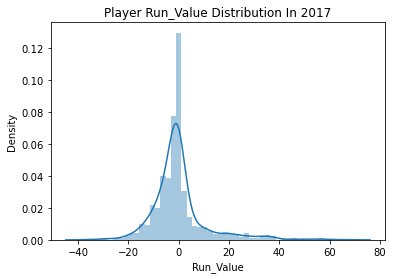

In [16]:
sns.distplot(player_value['Run_Value'])
plt.title('Player Run_Value Distribution In 2017')

# 팀별 누적 Run_value

In [17]:
re17['team']= np.where(re17['half']=='top',re17['away_team'],re17['home_team'])
team_value = re17.groupby(['team'])['Run_Value'].sum().reset_index()
team_value.sort_values(by='Run_Value', ascending=False)

,team,Run_Value
11,hou,152.296840
17,nya,107.485717
9,col,78.616716
8,cle,73.780465
6,chn,71.002092
16,min,69.583967
29,was,64.616716
1,ari,62.616716
27,tex,48.002092
14,mia,25.871093


### 팀별 누적 Run_Value가 팀의 승률과 얼마나 연관이 있을까? 


In [18]:
wpc = pd.read_excel('data/wpcsal2016-17.xlsx')
wpc_17 = wpc[['team', 'wpc2017', 'lahteamname']]
team_value = pd.merge(team_value, wpc_17, on='team')

In [19]:
team_value.sort_values(by='wpc2017', ascending=False).reset_index().drop('index', axis=1)

,team,Run_Value,wpc2017,lahteamname
0,lan,17.747715,0.641975,LAN
1,cle,73.780465,0.629630,CLE
2,hou,152.296840,0.623457,HOU
3,was,64.616716,0.598765,WAS
4,ari,62.616716,0.574074,ARI
5,bos,9.445347,0.574074,BOS
6,chn,71.002092,0.567901,CHN
7,nya,107.485717,0.561728,NYA
8,col,78.616716,0.537037,COL
9,mil,-11.383284,0.530864,MIL


In [24]:
team_value.corr()

,Run_Value,wpc2017
Run_Value,1.000000,0.716763
wpc2017,0.716763,1.000000


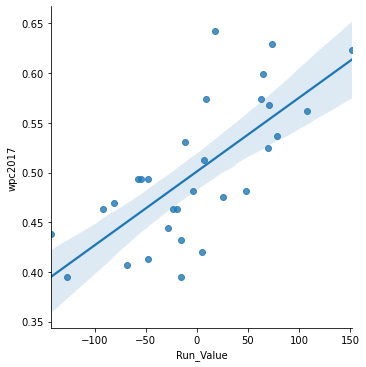

In [25]:
sns.lmplot(x='Run_Value', y='wpc2017', data=team_value)

팀의 Run_Value와 승률은 꽤 높은 상관관계를 가지고 있다.

In [26]:
import statsmodels.formula.api as smf

In [27]:
rv_wpc = smf.ols(formula = 'wpc2017 ~ Run_Value', data=team_value).fit()
rv_wpc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                wpc2017   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     29.58
Date:                Sun, 29 Aug 2021   Prob (F-statistic):           8.36e-06
Time:                        21:41:04   Log-Likelihood:                 48.032
No. Observations:                  30   AIC:                            -92.06
Df Residuals:                      28   BIC:                            -89.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5010      0.009     54.315      0.000       0.482       0.520
Run_Value      0.0007      0.000      5.439      0.000       0.000       0.001
==============================================================================
Omnibus:                        0.728   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.378
Skew:                           0.275   Prob(JB):                        0.828
Kurtosis:                       2.968   Cond. No.                         67.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

회귀계수=0.0007 (통계적으로 유의)       
팀 Run_Value가 1차이가 나면 팀 승률이 0.0007(0.07% 포인트) 차이난다.